In [14]:
import operator
# https://github.com/DEAP/deap/issues/491
import numpy as np
import pygraphviz as pgv
import matplotlib.pyplot as plt
import math
import imageio
import pickle
import argparse
import networkx as nx
from cgp.graph import Graph
from cgp.population import Population
# import warnings
# warnings.simplefilter('ignore') 

In [15]:
############################################ Parameters ################################################
TARGET_EMOJI = 0 #@param "🦎"
MAX_HEIGHT = 15
POPULATION = 400
APPLY_SOBEL_FILTER = False
VISION = 1
TESTS_FOR_EACH_TREE = 1
N_TOTAL_STEPS = 100
GENS = 30
TARGET_IMG = np.full((25,25), .5)
SAVETO = None
RENDER = False
LIMIT = 10000

In [16]:
############################################ Test Images ################################################
def degrade_img():
    img = np.ones((25,25))
    for i in range(25):
        img[i][:] = 1 - (i*4)/100
    return img

def column_img():
    img = np.ones((25,25))
    for i in range(25):
        for j in range(25):
            if j == 12:
                img[i][j] = 1 - (i*4)/100
    return img

def plus_img():
    img = np.ones((25,25))
    for i in range(25):
        for j in range(25):
            if j == 12 or i == 12:
                img[i][j] = 0
    return img

def x_img():
    img = np.ones((25,25))
    for i in range(25):
        for j in range(25):
            if j == i or i + j == 24:
                img[i][j] = 0
    return img

def diagonal_img():
    img = np.ones((25,25))
    for i in range(25):
        for j in range(25):
            if i + j == 24:
                img[i][j] = 0
    return img

def inv_diagonal_img():
    img = np.ones((25,25))
    for i in range(25):
        for j in range(25):
            if i == j:
                img[i][j] = 0
    return img

def print_img(img):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.show()
    
def fitness(img, target_img):
    if img.shape != target_img.shape:
        raise
    loss = 0
    for i in range(target_img.shape[0]):
        for j in range(target_img.shape[1]):
            if img[i,j] > 1 or img[i,j] < 0 or math.isnan(img[i,j]):
                print(i, j, img[i,j])
                return -1000
            l = img[i,j] - target_img[i,j]
            loss += l**2
    return 1 - loss

In [17]:
############################################ Image Convertion functions ################################################
def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[..., :3], to_alpha(x)
    return np.clip(1.0-a+rgb, 0, 0.9999)

def to_alpha(x):
    return np.clip(x[..., 3:4], 0, 0.9999)

def to_gray(x):
    rgb = to_rgb(x)
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def load_emoji(index, path="data/emoji.png", size=40):
    im = imageio.imread(path)
    emoji = np.array(im[:, index*size:(index+1)*size].astype(np.float32))
    emoji /= 255.0
    gray_emoji = to_gray(emoji)
    return gray_emoji

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()
    
def grayscale_to_rgb(img):
    blue_channel = np.array(img*255, dtype = 'uint8')
    red_channel = np.array(img*255, dtype = 'uint8')
    green_channel = np.array(img*255, dtype = 'uint8')
    
    return np.stack((red_channel, blue_channel, green_channel), axis=2)

def create_base_env(target_image):
    env = np.copy(target_image)
    env = np.pad(np.copy(target_image), 1)
    env[:] = 1
    a, b = env.shape
    env[int(a/2)][int(b/2)] = 0
    return env
    
def save_graph(expr, name="out"):
    nodes, edges, labels = gp.graph(expr)
    g = pgv.AGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    g.layout(prog="dot")

    for i in nodes:
        n = g.get_node(i)
        n.attr["label"] = labels[i]
    g.draw(name+".png")
    
def draw_graph(expr):
    nodes, edges, labels = gp.graph(expr)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.graphviz_layout(g, prog="dot")

    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)
    plt.show()

In [18]:
############################################ Automata  ################################################
sobel_x = [[-1, 0, +1], [-2, 0, +2], [-1, 0, +1]]
sobel_y = np.transpose(sobel_x)
class CA_2D_model:
    def __init__(self, length, width, individual, *, vision=VISION):
        self.action = toolbox.compile(individual)
        self.individual = individual
        self.len = length + 2*vision
        self.wid = width + 2*vision
        self.vision = vision
        self.vision_size = (vision+2)**2

        # The size of the pad is dependent on how far each cell sees to updates its valus
        self.original = np.pad(np.zeros((length, width)),1)
        self.original[:] = 1 # make all cells white
        self.original[int(self.len/2)][int(self.wid/2)] = 0 # make the center cell black

        self.ca = np.copy(self.original)
    
    def reset_ca(self):
        self.ca = np.copy(self.original)

    def get_observation(self, i, j):
        observation = self.ca[i-self.vision:i+self.vision+1, j-self.vision:j+self.vision+1]
        if APPLY_SOBEL_FILTER and observation.shape == sobel_y.shape:
            x = np.multiply(sobel_x, observation) # apply sobel filter for edge detection
            y = np.multiply(sobel_y, observation) # apply sobel filter for edge detection
            return np.append(observation.reshape(-1), [x.reshape(-1), y.reshape(-1)])
        return observation.reshape(-1)

    def new_cell_value(self, i, j):
        # checking ig it is a pad
        if i-self.vision < 0 or j-self.vision < 0:
            return 1
        if i+self.vision >= self.len or j + self.vision >= self.wid:
            return 1

        observation = self.get_observation(i, j)
        if observation[0:self.vision_size].sum() >= 1 * self.vision_size: # checking if the cell is alive
            return 1
        value = self.action(*observation)
        value = round(value, 5)
        value = limit(value, -1*LIMIT, LIMIT)
        return value

    def update(self):
        new_ca = np.copy(self.ca)
        for i in range(self.vision, self.len - self.vision): # skipping pad
            for j in range(self.vision, self.wid - self.vision): # skipping pad
                new_ca[i, j] = self.new_cell_value(i, j)
        if (new_ca == self.ca).all(): # checking if the cell updated or not
            return False
        self.ca = new_ca
        return True

    def remove_pad(self):
        return self.ca[self.vision:self.len - self.vision, self.vision:self.wid - self.vision]

    def fitness(self, target_image):
        ca = self.remove_pad()
        if target_image.shape != ca.shape:
            raise
        loss = 0
        for i in range(target_image.shape[0]):
            for j in range(target_image.shape[1]):
                if ca[i,j] > 1 or ca[i,j] < 0: # Checking if the cell is in the right interval
                    return -1000
                l = ca[i,j] - target_image[i,j]
                loss += l**2
        return 1 - loss

In [19]:
############################################ Creating GP and image ################################################
input_size = (VISION+2)**2
if APPLY_SOBEL_FILTER:
    input_size *= 3

############################################ Node Custom Operations ################################################

addition = lambda x, y: x+y
multiplication = lambda x, y: x*y
subtraction = lambda x, y: x-y
constant = lambda x: x
protected_div = lambda x, y: 1 if y == 0 else x/y
increment = lambda x: x+1
invert = lambda x: -x

seed = 2002
Graph.rng = np.random.RandomState(seed)

Population.add_operation(arity=1, func=constant, string="x")
Population.add_operation(arity=1, func=increment, string="x+1")
Population.add_operation(arity=1, func=invert, string="-x")
Population.add_operation(arity=2, func=addition, string="x+y")
Population.add_operation(arity=2, func=multiplication, string="x*y")
Population.add_operation(arity=2, func=subtraction, string="x-y")
Population.add_operation(arity=2, func=protected_div, string="*x/y")

In [7]:
def eval_individual(individual, render=False):
    global TARGET_IMG
    shape = TARGET_IMG.shape
    ca = CA_2D_model(shape[0], shape[1], individual)
    
    total_fitness = 0.0
    for i in range(TESTS_FOR_EACH_TREE):
        ca.reset_ca()

        for _ in range(N_TOTAL_STEPS):
            if render:
                print_img(ca.remove_pad())
                print(ca.fitness(TARGET_IMG))
            update = ca.update()
            if not update: # the automata got stable
                break

        total_fitness += ca.fitness(TARGET_IMG)  

    fitness = (total_fitness / TESTS_FOR_EACH_TREE) 
    return (fitness,)

def fitness_func(individual: Graph, tests):

    fitness = 0
    for t in tests:
        pred1, pred2 = individual.operate([t[0][0], t[0][1]])
        fitness += (t[1][0] - pred1)**2 + (t[1][1] - pred2)**2

        # pred1 = individual.operate(t[0])[0]
        # fitness += (t[1][0] - pred1)**2
    return  fitness

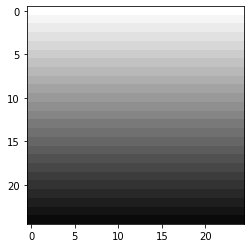

In [11]:
# TARGET_IMG = load_emoji(0, "data/stick.png", 25)
# TARGET_IMG = load_emoji(0, "data/brazil.png", 25)
# TARGET_IMG = column_img()
# TARGET_IMG = plus_img()
TARGET_IMG = degrade_img()
# TARGET_IMG = x_img()
# TARGET_IMG = diagonal_img()
# TARGET_IMG = load_emoji(command_line_args.img)
print_img(TARGET_IMG)

In [12]:
from time import sleep
from ipycanvas import Canvas, hold_canvas
def scale_matrix(matrix, scale):
    return np.kron(matrix, np.ones((scale,scale)))

def animate_individual(individual, steps, scale, t):
    ca = CA_2D_model(TARGET_IMG.shape[0], TARGET_IMG.shape[1], individual)

    canvas = Canvas(width=TARGET_IMG.shape[0]*scale, height=TARGET_IMG.shape[1]*scale)
    print(canvas)
    display(canvas)

    for i in range(steps):
        with hold_canvas(canvas):
            # Clear the old animation step
            canvas.clear()
            # Perfom all your drawings here
            img = grayscale_to_rgb(scale_matrix(ca.remove_pad(), scale))
            _ = canvas.put_image_data(img, 0, 0)

            ca.update()

        # Animation frequency ~50Hz = 1./50. seconds
        sleep(t)

In [ ]:
pop = toolbox.population(n=POPULATION)
hof = tools.HallOfFame(5)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
mstats = tools.MultiStatistics(fitness=stats_fit)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.9, 0.3, 10, stats=mstats,
                               halloffame=hof, verbose=True)

   	      	                        fitness                        
   	      	-------------------------------------------------------
gen	nevals	avg     	gen	max   	min  	nevals	std    
0  	400   	-314.498	0  	-51.25	-1000	400   	291.939
1  	379   	-196.492	1  	-51.25	-1000	379   	154.105
2  	374   	-184.015	2  	-46.7 	-1000	374   	214.659


In [ ]:
halloffame = None
file = "testes/stick_100g_100s.pkl"
TARGET_IMG = degrade_img()
N_TOTAL_STEPS = 25
aux = open(file, "rb")
cp = pickle.load(aux)
halloffame = cp["halloffame"]

In [ ]:
animate_individual(halloffame[2], 100, 10, 0.02)